# GPT-like multimodal chatbot


<img src="https://github.com/user-attachments/assets/2ab9b499-7ca2-4ae9-af72-ccc775f30b4e" width="100" align="left" /> + 
<img src="https://cdn.mos.cms.futurecdn.net/VgGxJABA8DcfAMpPPwdv6a.jpg" width="200" align="center"/>

[https://github.com/dagworks-inc/burr](https://github.com/dagworks-inc/burr) by DAGWorks Inc. (YCW23 & StartX).

Take🏠:

 - high level what is Burr
 - what you can do with Burr (observing state & being able to debug a particular point in time)
 - watch a walkthrough of this [notebook here](https://youtu.be/hqutVJyd3TI).

## Agentic Problems
1. Why did this LLM call fail?
2. Oh crap my code broke, why?
3. Things went off the rails, but where?
4. etc

## Monitoring for the win, right?
Well but ... monitoring doesn't help you debug & complete your dev loop

1. How do I debug that quickly?
2. How do I fix the inputs/code, and restart my agent?
3. What if my agent was 20+ steps in … do I have to restart from step 0? or can I go to a specific point in time?


## Solution: Burr
(Complements our other framework [Hamilton](https://github.com/dagWorks-Inc/hamilton))

## 1. Agent application is modeled as State + Actions --> Graph
Straightforward multi-modal example below:

In [13]:
import copy

from IPython.display import Image, display
from IPython.core.display import HTML 
import openai

from burr.core import ApplicationBuilder, State, default, graph, when
from burr.core.action import action
from burr.tracking import LocalTrackingClient

MODES = {
    "answer_question": "text",
    "generate_image": "image",
    "generate_code": "code",
    "unknown": "text",
}


@action(reads=[], writes=["chat_history", "prompt"])
def process_prompt(state: State, prompt: str) -> State:
    result = {"chat_item": {"role": "user", "content": prompt, "type": "text"}}
    state = state.append(chat_history=result["chat_item"])
    state = state.update(prompt=prompt)
    return state


@action(reads=["prompt"], writes=["mode"])
def choose_mode(state: State) -> State:
    prompt = (
        f"You are a chatbot. You've been prompted this: {state['prompt']}. "
        f"You have the capability of responding in the following modes: {', '.join(MODES)}. "
        "Please respond with *only* a single word representing the mode that most accurately "
        "corresponds to the prompt. Fr instance, if the prompt is 'draw a picture of a cat', "
        "the mode would be 'generate_image'. If the prompt is "
        "'what is the capital of France', the mode would be 'answer_question'."
        "If none of these modes apply, please respond with 'unknown'."
    )

    llm_result = openai.Client().chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant"},
            {"role": "user", "content": prompt},
        ],
    )
    content = llm_result.choices[0].message.content
    mode = content.lower()
    if mode not in MODES:
        mode = "unknown"
    result = {"mode": mode}
    return state.update(**result)


@action(reads=["prompt", "chat_history"], writes=["response"])
def prompt_for_more(state: State) -> State:
    result = {
        "response": {
            "content": "None of the response modes I support apply to your question. "
                       "Please clarify?",
            "type": "text",
            "role": "assistant",
        }
    }
    return state.update(**result)


@action(reads=["prompt", "chat_history", "mode"], writes=["response"])
def chat_response(
        state: State, prepend_prompt: str, model: str = "gpt-3.5-turbo"
) -> State:
    
    chat_history = copy.deepcopy(state["chat_history"])
    chat_history[-1]["content"] = f"{prepend_prompt}: {chat_history[-1]['content']}"
    chat_history_api_format = [
        {
            "role": chat["role"],
            "content": chat["content"],
        }
        for chat in chat_history
    ]
    client = openai.Client()
    result = client.chat.completions.create(
        model=model,
        messages=chat_history_api_format,
    )
    text_response = result.choices[0].message.content
    result = {"response": {"content": text_response, "type": MODES[state["mode"]], "role": "assistant"}}
    return state.update(**result)


@action(reads=["prompt", "chat_history", "mode"], writes=["response"])
def image_response(state: State, model: str = "dall-e-2") -> State:
    """Generates an image response to the prompt. Optional save function to save the image to a URL."""
    # raise ValueError("Demo error")
    client = openai.Client()
    result = client.images.generate(
        model=model, prompt=state["prompt"], size="1024x1024", quality="standard", n=1
    )
    image_url = result.data[0].url
    result = {"response": {"content": image_url, "type": MODES[state["mode"]], "role": "assistant"}}
    return state.update(**result)


@action(reads=["response", "mode"], writes=["chat_history"])
def response(state: State) -> State:
    # you'd do something specific here based on prior state
    result = {"chat_item": state["response"]}
    return state.append(chat_history=result["chat_item"])


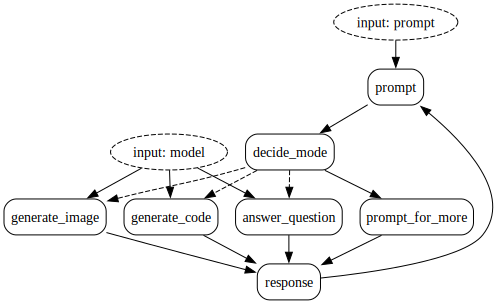

In [14]:
# Built the graph.
base_graph = (
    graph.GraphBuilder()
    .with_actions(
        # these are the "nodes" 
        prompt=process_prompt,
        decide_mode=choose_mode,
        generate_image=image_response,
        generate_code=chat_response.bind(
            prepend_prompt="Please respond with *only* code and no other text (at all) to the following:",
        ),
        answer_question=chat_response.bind(
            prepend_prompt="Please answer the following question:",
        ),
        prompt_for_more=prompt_for_more,
        response=response,
    )
    .with_transitions(
        # these are the edges between nodes, based on state.
        ("prompt", "decide_mode", default),
        ("decide_mode", "generate_image", when(mode="generate_image")),
        ("decide_mode", "generate_code", when(mode="generate_code")),
        ("decide_mode", "answer_question", when(mode="answer_question")),
        ("decide_mode", "prompt_for_more", default),
        (
            ["generate_image", "answer_question", "generate_code", "prompt_for_more"],
            "response",
        ),
        ("response", "prompt", default),
    )
    .build()
)
base_graph.visualize()

## 2. Build application --> built in checkpointing & tracking

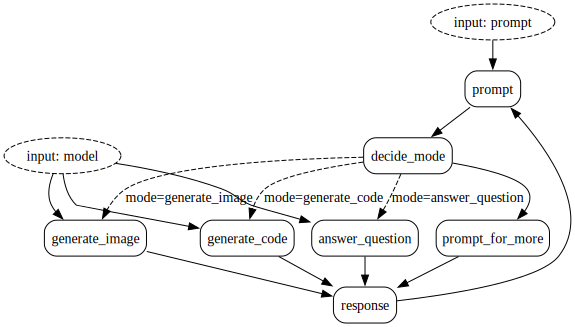

In [11]:
tracker = LocalTrackingClient(project="agent-demo")
app = (
    ApplicationBuilder()
    .with_graph(base_graph)
    .initialize_from(
        tracker, 
        resume_at_next_action=True, 
        default_state={"chat_history": []},
        default_entrypoint="prompt",
    )
    .with_tracker(tracker)  # tracking + checkpointing; one line 🪄.
    .build()
)
app

## 3. Comes with a UI
View runs in the UI; Let's run the app first.

In [12]:
while True:
    user_input = input("Hi, how can I help?")
    if "quit" == user_input.lower():
        break
    last_action, action_result, app_state = app.run(
        halt_after=["response"], 
        inputs={"prompt": user_input}
    )
    last_message = app_state["chat_history"][-1]
    if last_message['type'] == 'image':
        display(Image(url=last_message["content"]))
    else:
        print(f"🤖: {last_message['content']}")

Hi, how can I help? what is the capital of France?


🤖: The capital of France is Paris.


Hi, how can I help? write hello world in java


🤖: ```
public class HelloWorld {
    public static void main(String[] args) {
        System.out.println("Hello, World!");
    }
}
```


Hi, how can I help? draw a pen



********************************************************************************
-------------------------------------------------------------------
Oh no an error! Need help with Burr?
Join our discord and ask for help! https://discord.gg/4FxBMyzW5n
-------------------------------------------------------------------
> Action: `generate_image` encountered an error!<
> State (at time of action):
{'__PRIOR_STEP': 'decide_mode',
 '__SEQUENCE_ID': 10,
 'chat_history': "[{'role': 'user', 'content': 'what is the capital ...",
 'mode': 'generate_image',
 'prompt': 'draw a pen',
 'response': "{'content': '```\\npublic class HelloWorld {\\n    p..."}
> Inputs (at time of action):
{'prompt': 'draw a pen'}
********************************************************************************
Traceback (most recent call last):
  File "/Users/stefankrawczyk/dagworks/burr/burr/core/application.py", line 534, in _step
    result, new_state = _run_single_step_action(
  File "/Users/stefankrawczyk/dagworks/

ValueError: Demo error

[Open the UI - http://localhost:7241/](http://localhost:7241)


## But something broke / I want to debug

Use:

* Application ID

In [15]:
app_id = "a6d74912-9ad6-42f0-9a18-bc17c5e77eaf"

In [16]:
resumed_app = (
    ApplicationBuilder()
    .with_graph(base_graph)
    .initialize_from(
        tracker,
        resume_at_next_action=True, 
        default_state={"chat_history": []},
        default_entrypoint="prompt",
    )
    .with_tracker(tracker)
    .with_identifiers(app_id=app_id)
    .build()
)

In [17]:
resumed_app.state["chat_history"]

[{'role': 'user', 'content': 'what is the capital of France?', 'type': 'text'},
 {'content': 'The capital of France is Paris.',
  'type': 'text',
  'role': 'assistant'},
 {'role': 'user', 'content': 'write hello world in java', 'type': 'text'},
 {'content': '```\npublic class HelloWorld {\n    public static void main(String[] args) {\n        System.out.println("Hello, World!");\n    }\n}\n```',
  'type': 'code',
  'role': 'assistant'},
 {'role': 'user', 'content': 'draw a pen', 'type': 'text'}]

In [18]:
while True:
    user_input = input("Hi, how can I help?")
    if "quit" == user_input.lower():
        break
    last_action, action_result, app_state = resumed_app.run(
        halt_after=["response"], 
        inputs={"prompt": user_input}
    )
    last_message = app_state["chat_history"][-1]
    if last_message['type'] == 'image':
        display(Image(url=last_message["content"]))
    else:
        print(f"🤖: {last_message['content']}")

Hi, how can I help? 


Hi, how can I help? what is the capital of England?


🤖: The capital of England is London.


Hi, how can I help? quit


## Actually what if I want to go back to a certain point in time?

* Fork: Start with state from any checkpoint

In [19]:
app_id = "a6d74912-9ad6-42f0-9a18-bc17c5e77eaf"
sequence_id = 4
# partition_key = ""

In [20]:
forked_app = (
    ApplicationBuilder()
    .with_graph(base_graph) # this could be different...
    .initialize_from(
        tracker,
        resume_at_next_action=True, 
        default_state={"chat_history": []},
        default_entrypoint="prompt",
        fork_from_app_id=app_id,
        fork_from_sequence_id=sequence_id,
        # fork_from_partition_key=partition_key
    )
    .with_tracker(tracker)
    .build()
)

In [21]:
# show prior forked state
forked_app.state["chat_history"]

[{'role': 'user', 'content': 'what is the capital of France?', 'type': 'text'},
 {'content': 'The capital of France is Paris.',
  'type': 'text',
  'role': 'assistant'},
 {'role': 'user', 'content': 'write hello world in java', 'type': 'text'}]

In [ ]:
while True:
    user_input = input("Hi, how can I help?")
    if "quit" == user_input.lower():
        break
    last_action, action_result, app_state = forked_app.run(
        halt_after=["response"], 
        inputs={"prompt": user_input}
    )
    last_message = app_state["chat_history"][-1]
    if last_message['type'] == 'image':
        display(Image(url=last_message["content"]))
    else:
        print(f"🤖: {last_message['content']}")

Hi, how can I help? 


🤖: ```java
public class HelloWorld {
    public static void main(String[] args) {
        System.out.println("Hello, World!");
    }
}
```


## Want to know more?

[Link to video walking through this notebook](https://youtu.be/hqutVJyd3TI).

[https://github.com/dagworks-inc/burr](https://github.com/dagworks-inc/burr)
<img src="burr_qrcode.png" width="125"/>

[Time Travel blog post & video:](https://blog.dagworks.io/p/travel-back-in-time-with-burr)

<a href="https://www.youtube.com/embed/98vxhIcE6NI?si=oV1BbSUCKa1UvX5P"><img src="https://img.youtube.com/vi/98vxhIcE6NI/0.jpg"> 
</img>
<a href="https://www.youtube.com/embed/98vxhIcE6NI?si=oV1BbSUCKa1UvX5P">

More blogs @ `blog.dagworks.io` e.g. [async & streaming](https://blog.dagworks.io/p/streaming-chatbot-with-burr-fastapi)

More [examples](https://github.com/DAGWorks-Inc/burr/tree/main/examples/):

- e.g. [test case creation](https://burr.dagworks.io/examples/guardrails/creating_tests/)
- e.g. [multi-agent collaboration](https://github.com/DAGWorks-Inc/burr/tree/main/examples/multi-agent-collaboration)

Follow on Twitter & LinkedIn:

- https://x.com/burr_framework
- https://x.com/dagworks
- https://x.com/stefkrawczyk
- https://www.linkedin.com/in/skrawczyk/